In [17]:
import matplotlib.pyplot as plt

import os
import glob
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

from sklearn.metrics import roc_curve, auc

In [19]:
class ForgeryClassificationDataset(Dataset):
    def __init__(self, authentic_dir, forged_dir, img_size=128):
        self.img_paths = []
        self.labels = []
        self.size = img_size

        # authentic = label 0
        for p in sorted(glob.glob(os.path.join(authentic_dir, "*.png"))):
            self.img_paths.append(p)
            self.labels.append(0)

        # forged = label 1
        for p in sorted(glob.glob(os.path.join(forged_dir, "*.png"))):
            self.img_paths.append(p)
            self.labels.append(1)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]

        # load + resize
        img = Image.open(img_path).convert("RGB").resize((self.size, self.size))
        img_np = np.array(img).astype(np.float32) / 255.0

        # to CHW tensor
        img_t = torch.tensor(img_np).permute(2, 0, 1)
        label_t = torch.tensor(label, dtype=torch.long)

        return img_t, label_t

In [21]:
class ClassifierCNN(nn.Module):
    """
    Baseline CNN classifier.
    """
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),       # 64x64

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),       # 32x32

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),       # 16x16
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, 2),      # authentic vs forged
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [31]:
def train_classifier():

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    ds = ForgeryClassificationDataset(
        authentic_dir="data/train_images/authentic",
        forged_dir="data/train_images/forged",
        img_size=128
    )

    loader = DataLoader(ds, batch_size=16, shuffle=True, num_workers=0)

    model = ClassifierCNN().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=0.1)
    loss_fn = nn.CrossEntropyLoss()

    loss_history = []
    acc_history = []

    for epoch in range(5):
        model.train()
        total_loss = 0
        correct = 0

        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)

            logits = model(imgs)
            loss = loss_fn(logits, labels)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()
            correct += (logits.argmax(dim=1) == labels).sum().item()

        avg_loss = total_loss / len(loader)
        acc = correct / len(ds)

        loss_history.append(avg_loss)
        acc_history.append(acc)

        print(f"Epoch {epoch+1} | loss={avg_loss:.4f} | acc={acc:.3f}")

    torch.save(model.state_dict(), "baseline_classifier.pth")
    print("Saved baseline classifier.")

    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            probs = torch.softmax(logits, dim=1)[:, 1]  

            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())

    fpr, tpr, thresh = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, loss_history, acc_history, all_labels, all_probs

Using device: cpu
Epoch 1 | loss=777.5423 | acc=0.511
Epoch 2 | loss=0.6943 | acc=0.531
Epoch 3 | loss=0.6979 | acc=0.515
Epoch 4 | loss=0.6943 | acc=0.523
Epoch 5 | loss=0.6962 | acc=0.521
Saved baseline classifier.


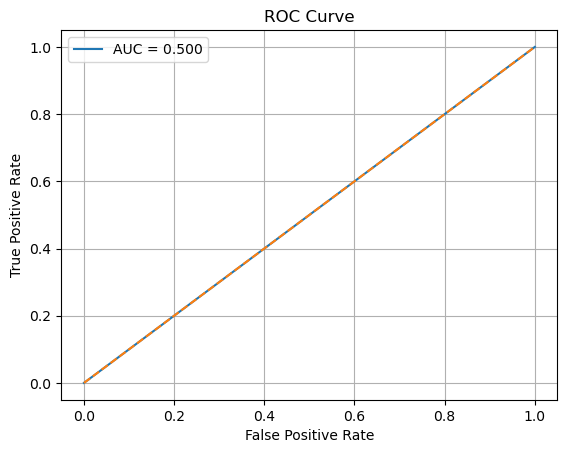

ValueError: too many values to unpack (expected 3)

In [33]:
model, loss_history, acc_history = train_classifier()

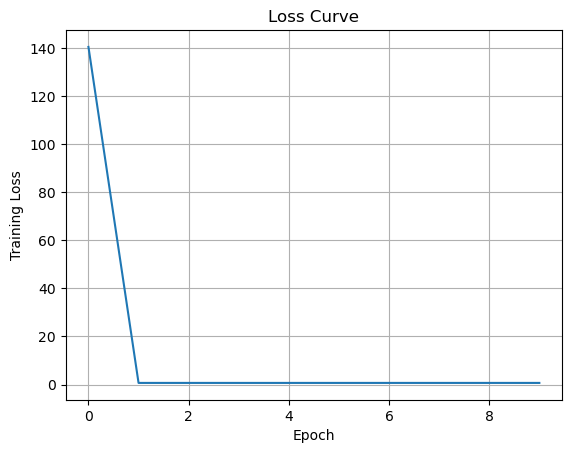

In [35]:
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Loss Curve")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

pred_labels = (np.array(all_probs) > 0.5).astype(int)
true_labels = np.array(all_labels)

print(classification_report(true_labels, pred_labels, target_names=["authentic", "forged"]))